In [2]:
!pip install yfinance

                                              0.0/72.4 kB ? eta -:--:--
     ---------------------------------------  71.7/72.4 kB 4.1 MB/s eta 0:00:01
     ---------------------------------------- 72.4/72.4 kB 1.4 MB/s eta 0:00:00
                                              0.0/62.6 kB ? eta -:--:--
     ---------------------------------------- 62.6/62.6 kB ? eta 0:00:00
                                              0.0/314.6 kB ? eta -:--:--
     -------------------------------------- 314.6/314.6 kB 9.8 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
                                              0.0/2.9 MB ? eta -:--:--
     ------                                   0.5/2.9 MB 9.8 MB/s eta

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
conda-repo-cli 1.0.41 requires requests_mock, which is not installed.
transformers 2.1.1 requires sentencepiece, which is not installed.
conda-repo-cli 1.0.41 requires clyent==1.2.1, but you have clyent 1.2.2 which is incompatible.
conda-repo-cli 1.0.41 requires nbformat==5.4.0, but you have nbformat 5.7.0 which is incompatible.
conda-repo-cli 1.0.41 requires requests==2.28.1, but you have requests 2.31.0 which is incompatible.


Using the `yfinance` library we retrieve historical stock price data for Microsoft (MSFT). 

1. `msft = yf.Ticker("MSFT")`: This line creates a `Ticker` object for the Microsoft (MSFT) stock. The `yf.Ticker` class is part of the `yfinance` library, which is a popular library for accessing financial data from Yahoo Finance. The argument "MSFT" is the ticker symbol for Microsoft.

2. `msft_hist = msft.history(period="max")`: This line retrieves the historical stock price data for Microsoft. The `history` method is used to get historical market data. The `period="max"` argument indicates that you want to retrieve data for the maximum available time period. The result is stored in the `msft_hist` variable, which is typically a pandas DataFrame containing information such as open, high, low, close prices, and volume for each trading day.

In summary, these two lines of code fetch the historical stock price data for Microsoft using the `yfinance` library and store it in the `msft_hist` variable for further analysis or visualization. Keep in mind that you need to have the `yfinance` library installed (`pip install yfinance`) for this code to work.

In [1]:
import yfinance as yf
import os
import json
import pandas as pd

DATA_PATH = "msft_data..json"

if os.path.exists(DATA_PATH):
    # Read from file if we've already downloaded the data.
    with open(DATA_PATH) as f:
        msft_hist = pd.read_json(DATA_PATH)
else:
    msft = yf.Ticker("MSFT")
    msft_hist = msft.history(period="max")

    # Save file to json in case we need it later.  This prevents us from having to re-download it every time.
    msft_hist.to_json(DATA_PATH)


C:\Users\elzab\anaconda3\Lib\site-packages\yfinance\base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [2]:
msft_hist.shape

(9554, 7)

In [3]:
msft_hist.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1986-03-13 00:00:00-05:00,0.054893,0.062965,0.054893,0.060274,1031788800,0.0,0.0
1986-03-14 00:00:00-05:00,0.060274,0.063504,0.060274,0.062427,308160000,0.0,0.0
1986-03-17 00:00:00-05:00,0.062427,0.064042,0.062427,0.063503,133171200,0.0,0.0
1986-03-18 00:00:00-05:00,0.063504,0.064042,0.061350,0.061889,67766400,0.0,0.0
1986-03-19 00:00:00-05:00,0.061889,0.062427,0.060274,0.060812,47894400,0.0,0.0


In [4]:
import matplotlib 

<Axes: xlabel='Date'>

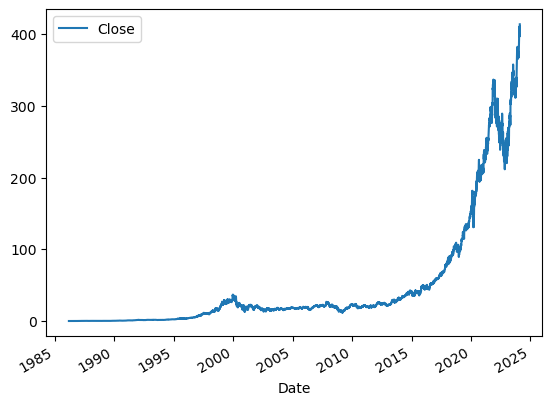

In [5]:
# Visualize microsoft stock prices
msft_hist.plot.line(y="Close", use_index=True)

Now, let's prepare the data so we can make predictions. As we mentioned in the introduction, we'll be predicting if the price will go up or down tomorrow based on data from today.

First, we'll identify a target that we're trying to predict. Our target will be if the price will go up or down tomorrow. If the price went up, the target will be 1, and if it went down, the target will be 0.

Next, we'll shift the data from previous days "forward" one day, so we can use it to predict the target price. This ensures that we don't accidentally use data from the same day to make predictions! (a very common mistake)

Then, we'll combine both so we have our training data.

# Setting up the target
First, we setup the target.

We do this by first copying the Close column to a new DataFrame called data and renaming it to actual_close. This ensures that we can continue to see the value that the stock actually closed at on each day. (we'll be shifting things around later, so it's important to preserve this).

Then, we setup our target by doing the following:

Using the pandas rolling method across every 2 rows of the DataFrame. This will first look at ('1986-03-13', '1986-03-14'), then ('1986-03-14', '1986-03-17'), and so on across the DataFrame.
We will compare the second row to the first row to see if it is greater. If it is, return 1, otherwise 0.
We then just look at the Close column.
As you can see above, the Target column now indicates if the price went up or down on the given day. If Target is 1, the price went up. If Target is 0, the price went down.

This is what we want our machine learning model to predict!

In [6]:
# Ensure we know the actual closing price
data = msft_hist[["Close"]]
data = data.rename(columns = {'Close':'Actual_Close'})

In [7]:
data["Target"]=msft_hist.rolling(2).apply(lambda x:x.iloc[1]>x.iloc[0])["Close"]

The order of execution for the original line of code:

```python
data["Target"] = msft_hist.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Close"]
```

1. **`msft_hist.rolling(2)`**:
   - A rolling window of size 2 is applied to the entire `msft_hist` DataFrame. It considers each numeric column separately, including the "Close" column.

2. **`apply(lambda x: x.iloc[1] > x.iloc[0])`**:
   - The `apply` function is then applied to each rolling window. The lambda function checks if the second element (index 1) in each numeric column's rolling window is greater than the first element (index 0). This results in a boolean DataFrame where each column represents whether the condition is true or false for that column's rolling window.

3. **`["Close"]`**:
   - The resulting boolean DataFrame is indexed using `["Close"]`, selecting only the boolean values from the "Close" column's rolling window.

4. **`data["Target"] = ...`**:
   - The boolean values obtained from the rolling window calculation on the "Close" column are assigned to a new column named "Target" in the `data` DataFrame.

In summary, the line of code calculates a rolling window of size 2 on all numeric columns of `msft_hist`, checks if the second element is greater than the first for each column's rolling window, and assigns the resulting boolean values from the "Close" column to a new "Target" column in the `data` DataFrame.

In [8]:
data.head()

,Actual_Close,Target
Date,,
1986-03-13 00:00:00-05:00,0.060274,NaN
1986-03-14 00:00:00-05:00,0.062427,1.0
1986-03-17 00:00:00-05:00,0.063503,1.0
1986-03-18 00:00:00-05:00,0.061889,0.0
1986-03-19 00:00:00-05:00,0.060812,0.0


# Shifting data "forward"
Next, we'll use the DataFrame shift method to move all rows "forward" one trading day.

As you can see, the prices for 1986-03-13 are now associated with 1986-03-14, and every other price is shifted up one row. This is to ensure that we're predicting future prices using past data.

If we didn't do this, we'd be using data from 03-14 to predict prices on 03-14. Instead, we need to use data from 03-13 to predict prices on 03-14. If we don't do this, our model will look amazing when we're testing it, but won't work at all in the real world. In the real world, we don't actually know the price tomorrow, so we can't use it to make our predictions.

In [9]:
msft_prev = msft_hist.copy()
msft_prev = msft_prev.shift(1)

In [10]:
msft_prev.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1986-03-13 00:00:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986-03-14 00:00:00-05:00,0.054893,0.062965,0.054893,0.060274,1.031789e+09,0.0,0.0
1986-03-17 00:00:00-05:00,0.060274,0.063504,0.060274,0.062427,3.081600e+08,0.0,0.0
1986-03-18 00:00:00-05:00,0.062427,0.064042,0.062427,0.063503,1.331712e+08,0.0,0.0
1986-03-19 00:00:00-05:00,0.063504,0.064042,0.061350,0.061889,6.776640e+07,0.0,0.0


In [11]:
predictors = ["Close","Volume","Open","High","Low"]
data=data.join(msft_prev[predictors]).iloc[1:]

In [12]:
data.head()

,Actual_Close,Target,Close,Volume,Open,High,Low
Date,,,,,,,
1986-03-14 00:00:00-05:00,0.062427,1.0,0.060274,1.031789e+09,0.054893,0.062965,0.054893
1986-03-17 00:00:00-05:00,0.063503,1.0,0.062427,3.081600e+08,0.060274,0.063504,0.060274
1986-03-18 00:00:00-05:00,0.061889,0.0,0.063503,1.331712e+08,0.062427,0.064042,0.062427
1986-03-19 00:00:00-05:00,0.060812,0.0,0.061889,6.776640e+07,0.063504,0.064042,0.061350
1986-03-20 00:00:00-05:00,0.059198,0.0,0.060812,4.789440e+07,0.061889,0.062427,0.060274


In [13]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Create a random forest classification model.  Set min_samples_split high to ensure we don't overfit.
model = RandomForestClassifier(n_estimators=100, min_samples_split=200, random_state=1)

1. Import Necessary Libraries:

from sklearn.ensemble import RandomForestClassifier: This line imports the RandomForestClassifier class from scikit-learn's ensemble module. The RandomForestClassifier is an ensemble learning method for classification.

import numpy as np: This line imports the NumPy library and gives it the alias 'np'. NumPy is commonly used for numerical operations in Python.

2. Create a Random Forest Classification Model:

model = RandomForestClassifier(n_estimators=100, min_samples_split=200, random_state=1): This line instantiates a RandomForestClassifier object with the following parameters:

n_estimators=100: Specifies the number of decision trees in the random forest. In this case, the model will consist of 100 decision trees.

min_samples_split=200: Sets the minimum number of samples required to split an internal node. This parameter helps control overfitting. A higher value (such as 200) ensures that a node is only split if it contains at least 200 samples, which can help prevent overfitting.

In the context of decision trees and machine learning, "samples" refer to the individual data points or instances in your dataset. Each row or observation in your dataset is considered a sample.

random_state=1: Sets the seed for randomness in the model. Providing a fixed random state ensures reproducibility, meaning the model will produce the same results if run with the same parameters and data.

The model variable now holds an instance of the RandomForestClassifier with the specified configuration.

This random forest classification model can be further trained on a dataset using the fit method, and then used to make predictions on new data.

# Training the model
Once we've setup the model, we can train it on the last 100 rows of the dataset. We're using all of the data except the last 100 rows to predict the last 100 rows. When you're working with time series data, it's important to never use future data to predict the past.

The fit method will train the model using our predictors to predict the Target.

In [14]:
train = data.iloc[:-100]
test = data.iloc[-100:]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=200, random_state=1)

In [15]:
from sklearn.metrics import precision_score 
# Evaluate error of predictions 
preds = model.predict(test[predictors]) 
preds = pd.Series(preds, index=test.index) 
precision_score(test["Target"], preds)

0.6

A precision score of 0.6 (or 60%) means that **out of all the instances predicted as positive by your machine learning model, 60% of them were correct**, or in other words, were true positive predictions. Precision is a measure of the accuracy of positive predictions made by a classifier.

Here's a breakdown of the components used to calculate precision:

- **True Positives (TP):** Instances that are actually positive and are correctly predicted as positive by the model.

- **False Positives (FP):** Instances that are actually negative but are incorrectly predicted as positive by the model.

Precision is calculated using the formula:

\[ \text{Precision} = \frac{TP}{TP + FP} \]

In your case, a precision of 0.6 means that 60% of the instances predicted as positive by the model were indeed positive, while 40% were false positives.

A higher precision score indicates a better ability of the model to make accurate positive predictions, minimizing the number of false positives. However, precision should be considered alongside other metrics (such as recall, accuracy, and F1-score) to get a comprehensive understanding of the model's performance, especially in imbalanced datasets where the number of positive and negative instances differs significantly.

<Axes: xlabel='Date'>

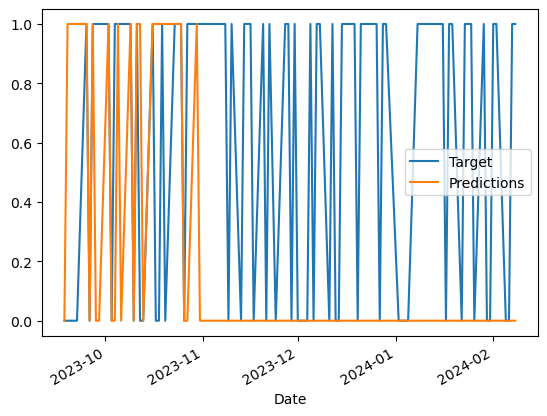

In [16]:
combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)
combined.plot()

# Backtesting
Our model isn't great, but luckily we can still improve it. Before we do that, let's figure out how to make predictions across the entire dataset, not just the last 100 rows. This will give us a more robust error estimate. The last 100 days may have has atypical market conditions or other issues that make error metrics on those days unrealistic for future predictions (which are what we really care about).

To do this, we'll need to backtest. Backtesting ensures that we only use data from before the day that we're predicting. If we use data from after the day we're predicting, the algorithm is unrealistic (in the real world, you won't be able to use future data to predict that past!).

Our backtesting method will loop over the dataset, and train a model every 750 rows. We'll make it a function so we can avoid rewriting the code if we want to backtest again.

In the backtesting function, we will:

Split the training and test data
Train a model
Make predictions on the test data using predict_proba - this is because we want to really optimize for true positives. By default, the threshold for splitting 0/1 is .5, but we can set it to different values to tweak the precision. If we set it too high, we'll make fewer trades, but will have a lower potential for losses.

In [17]:
def backtest(data, model, predictors, start=1000, step=750):
    predictions = []
    # Loop over the dataset in increments
    for i in range(start, data.shape[0], step):
        # Split into train and test sets
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        
        # Fit the random forest model
        model.fit(train[predictors], train["Target"])
        
        # Make predictions
        preds = model.predict_proba(test[predictors])[:,1]
        preds = pd.Series(preds, index=test.index)
        preds[preds > .6] = 1
        preds[preds<=.6] = 0
        
        # Combine predictions and test values
        combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)
        
        predictions.append(combined)
    
    return pd.concat(predictions)

In [18]:
predictions = backtest(data, model, predictors)

In [19]:
predictions["Predictions"].value_counts()

0.0    7836
1.0     717
Name: Predictions, dtype: int64

In [20]:
precision_score(predictions["Target"], predictions["Predictions"])

0.504881450488145

# Improving accuracy
The model isn't very accurate, but at least now we can make predictions across the entire history of the stock. For this model to be useful, we have to get it to predict more accurately.

Let's add some more predictors to see if we can improve accuracy.

We'll add in some rolling means, so the model can evaluate the current price against recent prices. We'll also look at the ratios between different indicators.

# Rolling means
Rolling means are useful because they can help the algorithm evaluate the current price against the average price this week, quarter, or year. For example, if the price now is higher than the annual price, it could mean that the stock is on an upward trend.

To calculate the rolling averages, we'll again use the pandas rolling method to find the rolling mean of the Close column for different time horizons.

We can also tell the algorithm how many days in the last week the price has gone up. We can do this by using the pandas shift and rolling methods:

We'll shift the data forward, so we're not incorporating information from the current day into our predictor. If we didn't use shift, then the algorithm would have knowledge of the actual target. Find the 7-day rolling sum of the target. If the price went up for all 7 days, this would be 7. If it went up 0 days, this would be 0.

In [21]:
weekly_mean = data.rolling(7).mean()
quarterly_mean = data.rolling(90).mean()
annual_mean = data.rolling(365).mean()
weekly_trend = data.shift(1).rolling(7).mean()["Target"]

In [22]:
data["weekly_mean"] = weekly_mean["Close"] / data["Close"]
data["quarterly_mean"] = quarterly_mean["Close"] / data["Close"]
data["annual_mean"] = annual_mean["Close"] / data["Close"]

data["annual_weekly_mean"] = data["annual_mean"] / data["weekly_mean"]
data["annual_quarterly_mean"] = data["annual_mean"] / data["quarterly_mean"]
data["weekly_trend"] = weekly_trend

data["open_close_ratio"] = data["Open"] / data["Close"]
data["high_close_ratio"] = data["High"] / data["Close"]
data["low_close_ratio"] = data["Low"] / data["Close"]

In [23]:
full_predictors = predictors + ["weekly_mean", "quarterly_mean", "annual_mean", "annual_weekly_mean", "annual_quarterly_mean", "open_close_ratio", "high_close_ratio", "low_close_ratio", "weekly_trend"]
predictions = backtest(data.iloc[365:], model, full_predictors)

In [24]:
precision_score(predictions["Target"], predictions["Predictions"])

0.558303886925795

In [25]:
# Show how many trades we would make

predictions["Predictions"].value_counts()

0.0    7905
1.0     283
Name: Predictions, dtype: int64

<Axes: xlabel='Date'>

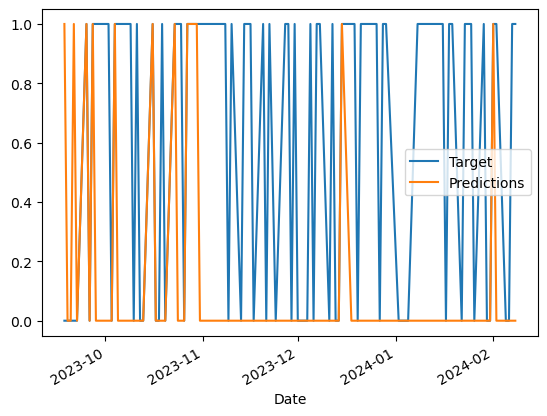

In [26]:
predictions.iloc[-100:].plot()

We can see that adding new predictors have improved the accuracy